<a href="https://colab.research.google.com/github/AliyevaO/Loan/blob/main/Loan_Approval_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Oleksandra Aliyeva
* 03.12.2022

In [1]:
#mount google disk
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import some necessary tools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

#import models for ML
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  RandomForestClassifier

#import accuracy, precision, recall, classification report, and confusion matrix scoring functions
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV 
from sklearn import set_config
set_config(display='diagram')

In [3]:
#download data and check the head
loan_df = pd.read_csv('/content/drive/MyDrive/Bootcamp/Data/partial_loan_dataset.csv')
loan_df.head()

,Loan_ID,Gender,Married,Dependent_No,Education,Self_Employed,Applicant_Income,CoApplicant_Income,Loan_Amount,Loan_Amount_Term,Credit History,Property_District,Loan_Status
0,23002,Male,True,3,Graduate,True,4315,19748.0,60000,300,1,OCR,1
1,23003,Female,True,3,Not Graduate,True,3331,29657.0,20000,60,0,OCR,1
2,23004,Male,True,3,Not Graduate,True,22494,29539.0,30000,240,1,RCR,1
3,23005,Male,True,2,Not Graduate,False,78117,12909.0,20000,60,0,OCR,1
4,23006,Male,False,2,Not Graduate,False,41976,45598.0,60000,300,1,RCR,1


In [4]:
#check general info
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loan_ID             5584 non-null   int64  
 1   Gender              5425 non-null   object 
 2   Married             5328 non-null   object 
 3   Dependent_No        5584 non-null   int64  
 4   Education           5218 non-null   object 
 5   Self_Employed       5584 non-null   bool   
 6   Applicant_Income    5584 non-null   int64  
 7   CoApplicant_Income  4999 non-null   float64
 8   Loan_Amount         5584 non-null   int64  
 9   Loan_Amount_Term    5584 non-null   int64  
 10  Credit History      5584 non-null   int64  
 11  Property_District   5578 non-null   object 
 12  Loan_Status         5584 non-null   int64  
dtypes: bool(1), float64(1), int64(7), object(4)
memory usage: 529.1+ KB


## Cleaning Data

In [5]:
#check for duplicates
loan_df.duplicated().sum()

0

* Data set doesn't have any duplicates.

In [6]:
#change boolean columns type for easie work later
repl_map = {True:1, False:0}
loan_df['Self_Employed'] = loan_df['Self_Employed'].replace(repl_map)

In [7]:
#check for any inconsistencies
data_types = loan_df.dtypes
str_cols = data_types[data_types=='object'].index
str_cols

Index(['Gender', 'Married', 'Education', 'Property_District'], dtype='object')

In [8]:
#loop to iterate through all columns with dtype - object
for col in str_cols:
    print(f'- {col}:')
    print (loan_df[col].value_counts(dropna=False))
    print('\n------------------------')

- Gender:
Male      3655
Female    1770
NaN        159
Name: Gender, dtype: int64

------------------------
- Married:
False    2677
True     2651
NaN       256
Name: Married, dtype: int64

------------------------
- Education:
Not Graduate    3082
Graduate        2136
NaN              366
Name: Education, dtype: int64

------------------------
- Property_District:
OCR    2797
RCR    1399
CCR    1382
NaN       6
Name: Property_District, dtype: int64

------------------------


* Data set doesn't have any inconsistente values.

In [9]:
#check for missing values
loan_df.isnull().sum()

Loan_ID                 0
Gender                159
Married               256
Dependent_No            0
Education             366
Self_Employed           0
Applicant_Income        0
CoApplicant_Income    585
Loan_Amount             0
Loan_Amount_Term        0
Credit History          0
Property_District       6
Loan_Status             0
dtype: int64

* Data set has missing values in 5 columns.

In [10]:
set_length = len(loan_df['Gender'])
gender_missing = loan_df['Gender'].isna().sum()
married_missing = loan_df['Married'].isna().sum()
education_missing = loan_df['Education'].isna().sum()
coap_inc_missing = loan_df['CoApplicant_Income'].isna().sum()
district_missing = loan_df['Property_District'].isna().sum()

In [11]:
# print % of missind data in each column
print('Percentage of missing values by columns:')
print(f'Gender - {round((gender_missing/set_length)*100, 1)} %')
print(f'Married - {round((married_missing/set_length)*100, 1)} %')
print(f'Education - {round((education_missing/set_length)*100, 1)} %')
print(f'CoApplicant Income - {round((coap_inc_missing/set_length)*100, 1)} %')
print(f'Property District  - {round((district_missing/set_length)*100, 1)} %')

Percentage of missing values by columns:
Gender - 2.8 %
Married - 4.6 %
Education - 6.6 %
CoApplicant Income - 10.5 %
Property District  - 0.1 %


In [12]:
#fill missing rows in Column 'Gender' with most frequent
loan_df['Gender'].fillna(loan_df['Gender'].mode()[0], inplace=True)

In [13]:
#fill missing data in column 'Married' with 'Unknown'
married_missing = loan_df['Married'].fillna('Unknown')
loan_df['Married'].fillna(value=married_missing, inplace=True)

In [14]:
#fill missing data in column 'Education' with 'Unknown'
education_missing = loan_df['Education'].fillna('Unknown')
loan_df['Education'].fillna(value=education_missing, inplace=True)

In [15]:
#fill missing data in column 'Property_District' with most frequent
loan_df['Property_District'].fillna(loan_df['Property_District'].mode()[0], inplace=True)

In [16]:
#fill missing data in column 'CoApplicant_Income' by grouping 'Gender', 'Loan_Status' and 'Loan_Amount' 
loan_df['CoApplicant_Income'] = loan_df.groupby(['Gender','Loan_Status','Loan_Amount'])['CoApplicant_Income'].transform(lambda x: x.fillna(x.mean()))

* For columns 'Gender' and 'Property_District' I used a stategy of 'most frequent'. Columns 'Married'and 'Education' I filled with 'Unknown', I don't see any columns that can help me to fill it in a better way. Last column that I was filling was 'CoApplicant_Income' I used mean value of groupby columns 'Gender', 'Loan_Status' and 'Loan_Amount'.  

In [17]:
#check for any missing values remain
loan_df.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependent_No          0
Education             0
Self_Employed         0
Applicant_Income      0
CoApplicant_Income    0
Loan_Amount           0
Loan_Amount_Term      0
Credit History        0
Property_District     0
Loan_Status           0
dtype: int64

In [18]:
#check the summary statistics of each numerical columns 
loan_df.describe()

,Loan_ID,Dependent_No,Self_Employed,Applicant_Income,CoApplicant_Income,Loan_Amount,Loan_Amount_Term,Credit History,Loan_Status
count,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000
mean,25793.500000,1.995881,0.597779,50658.552830,25369.031963,35333.094556,212.643266,0.664219,0.667264
std,1612.106283,1.414904,0.490390,28580.613968,13419.915480,17147.360206,102.963595,0.472305,0.471235
min,23002.000000,0.000000,0.000000,1002.000000,1002.000000,10000.000000,60.000000,0.000000,0.000000
25%,24397.750000,1.000000,0.000000,26090.250000,14752.000000,20000.000000,120.000000,0.000000,0.000000
50%,25793.500000,2.000000,1.000000,50909.500000,25374.735000,40000.000000,240.000000,1.000000,1.000000
75%,27189.250000,3.000000,1.000000,75769.750000,36205.500000,50000.000000,300.000000,1.000000,1.000000
max,28585.000000,4.000000,1.000000,99995.000000,49997.000000,60000.000000,360.000000,1.000000,1.000000


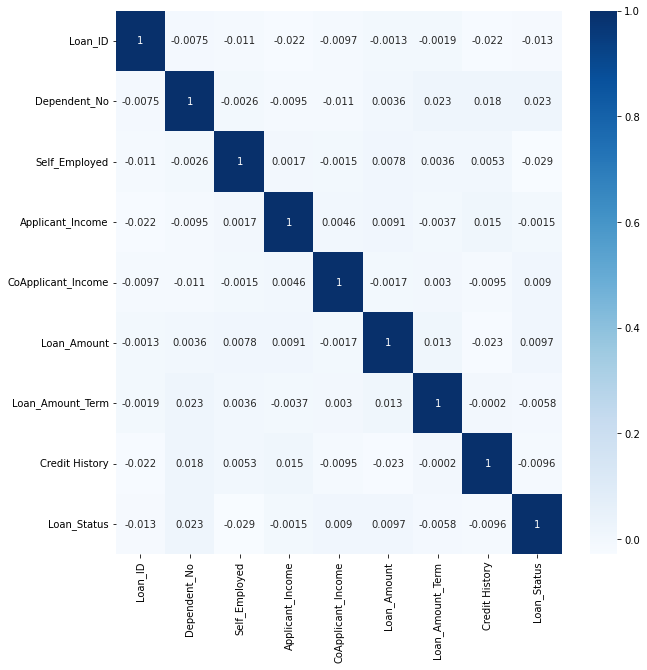

In [19]:
#create a heatmap to see correlation
plt.figure(figsize=(10,10))
sns.heatmap(loan_df.corr(), cmap = 'Blues', annot = True)

* We can see that numerical columns of our Data set have weak correlation. 

## Visualization


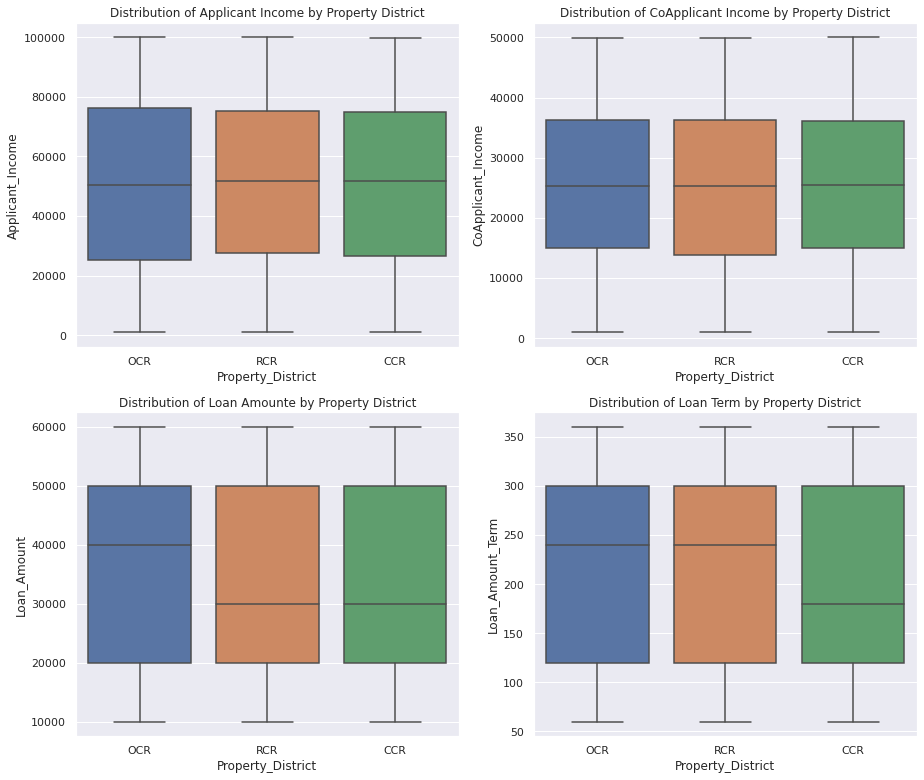

In [20]:
#create a 4 boxplots describing Property_District
sns.set_theme()
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(13,11))
sns.set_color_codes("pastel")
ax = sns.boxplot(data=loan_df, x='Property_District', y='Applicant_Income', ax=axes[0,0] )
ax.set_title('Distribution of Applicant Income by Property District')
ax2 = sns.boxplot(data=loan_df, x='Property_District', y='CoApplicant_Income',ax=axes[0,1]) 
ax2.set_title('Distribution of CoApplicant Income by Property District')
ax3 = sns.boxplot(data=loan_df, x='Property_District', y='Loan_Amount', ax=axes[1,0]) 
ax3.set_title('Distribution of Loan Amounte by Property District')
ax4 = sns.boxplot(data=loan_df, x='Property_District', y='Loan_Amount_Term', ax=axes[1,1]) 
ax4.set_title('Distribution of Loan Term by Property District')
fig.tight_layout(); 

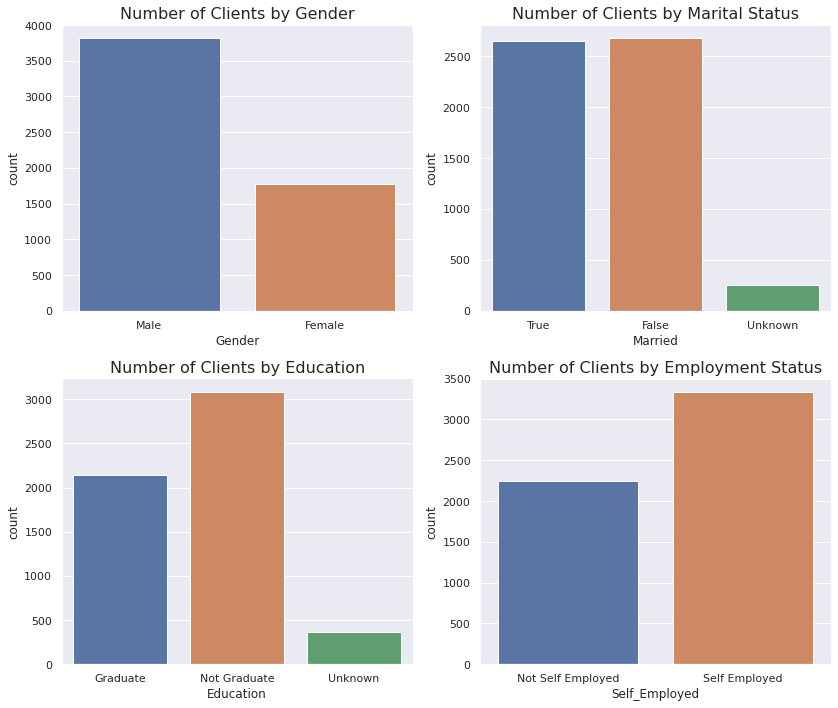

In [21]:
sns.set_theme()
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,10))
ax = sns.countplot(data=loan_df, x='Gender', ax=axes[0,0])
ax.set_title('Number of Clients by Gender', fontsize=16)
ax2 = sns.countplot(data=loan_df, x='Married', ax=axes[0,1])
ax2.set_title('Number of Clients by Marital Status', fontsize=16)
ax3 = sns.countplot(data=loan_df, x='Education', ax=axes[1,0])
ax3.set_title('Number of Clients by Education', fontsize=16)
ax4 = sns.countplot(data=loan_df, x='Self_Employed', ax=axes[1,1])
ax4.set_title('Number of Clients by Employment Status', fontsize=16)
ax4.set(xticklabels=['Not Self Employed', 'Self Employed'])
fig.tight_layout();

In this graph we can see that majority of our clients are men (68%). 
We have almost the same number of clients by their maritul status.
More clients didn't graduate.
There are more self emploded clients.

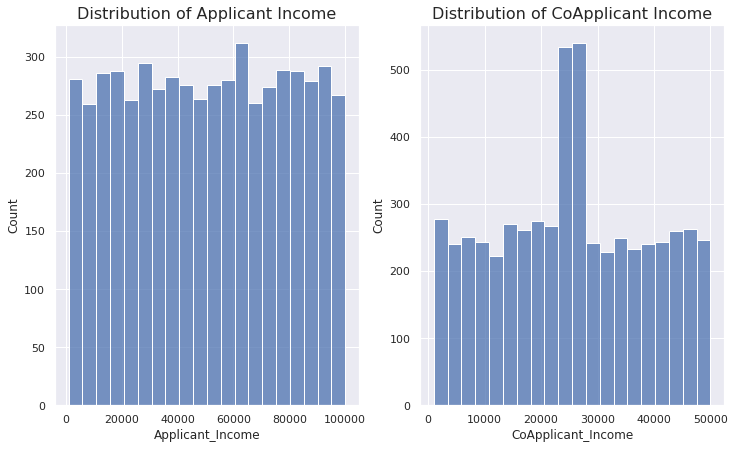

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(12,7))
ax = sns.histplot(data=loan_df, x='Applicant_Income', bins=20, ax=axes[0])
ax.set_title('Distribution of Applicant Income', fontsize=16)
ax2 = sns.histplot(data=loan_df, x='CoApplicant_Income', bins=20, ax=axes[1])
ax2.set_title('Distribution of CoApplicant Income', fontsize=16);

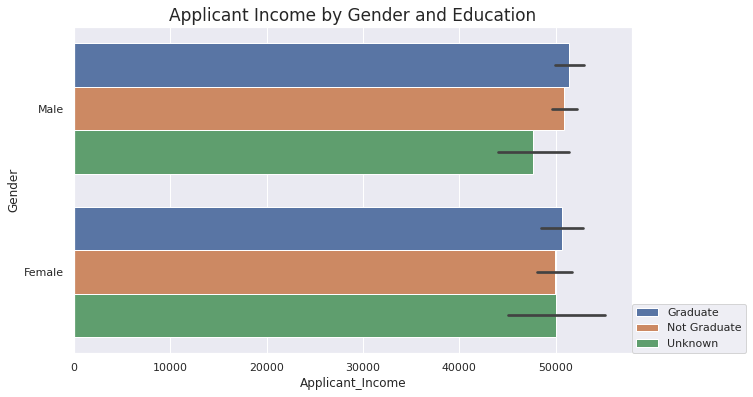

In [23]:
plt.figure(figsize=(10,6))
sns.barplot(data=loan_df, x='Applicant_Income', y='Gender', hue='Education')
plt.title('Applicant Income by Gender and Education', fontsize=17)
plt.legend(loc=[1,0]);

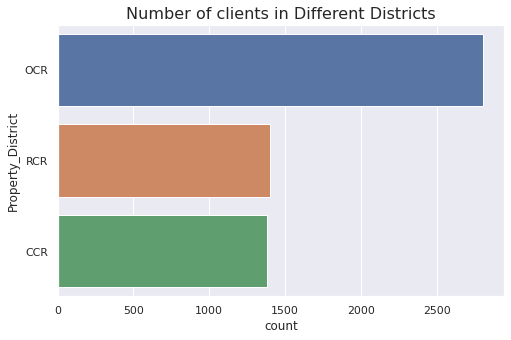

In [24]:
plt.figure(figsize=(8,5))
sns.countplot(data=loan_df, y='Property_District')
plt.title('Number of clients in Different Districts',fontsize=16); 

Most of the clients live in a district OCR.

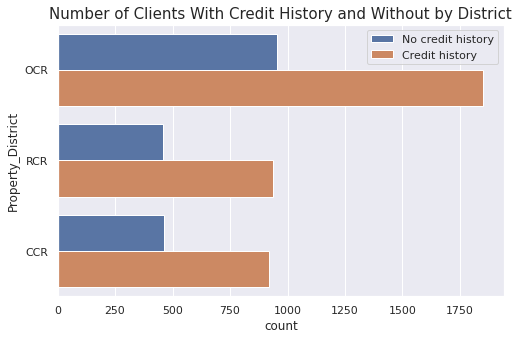

In [25]:
plt.figure(figsize=(8,5))
sns.countplot(data=loan_df, y='Property_District', hue='Credit History') 
plt.legend(['No credit history', 'Credit history'])
plt.title('Number of Clients With Credit History and Without by District', fontsize=15);

Most of the client have a credit history.

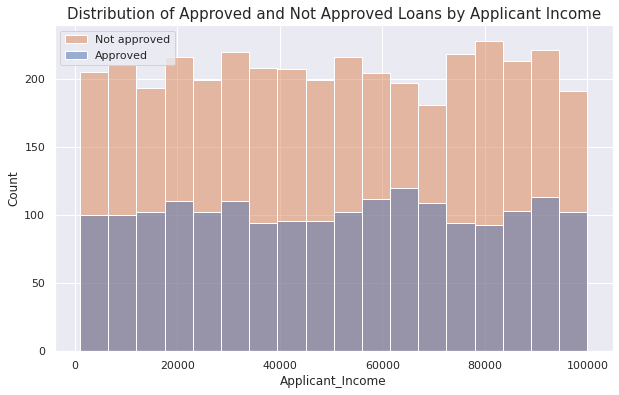

In [26]:
plt.figure(figsize=(10,6))
sns.histplot(data=loan_df, x='Applicant_Income', hue='Loan_Status')
plt.legend(['Not approved', 'Approved'])
plt.title('Distribution of Approved and Not Approved Loans by Applicant Income', fontsize=15);

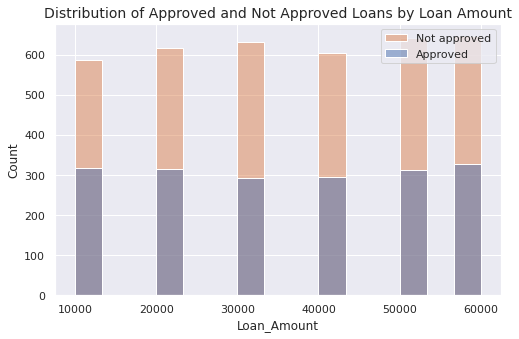

In [27]:
plt.figure(figsize=(8,5))
sns.histplot(data=loan_df, x='Loan_Amount', hue='Loan_Status')
plt.legend(['Not approved', 'Approved'])
plt.title('Distribution of Approved and Not Approved Loans by Loan Amount', fontsize=14);

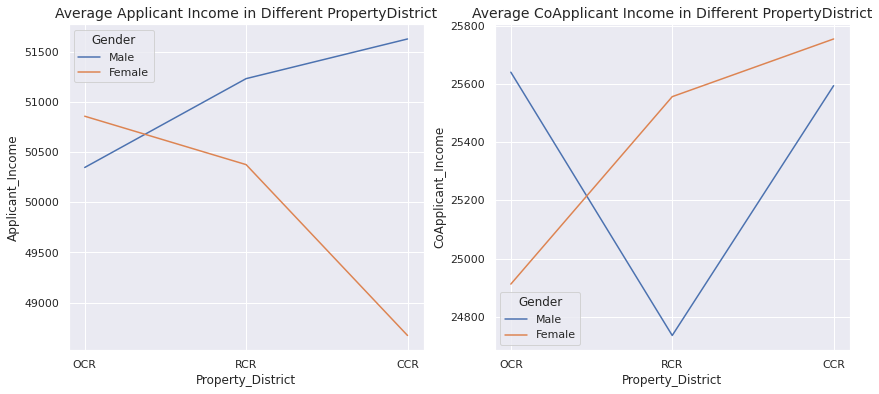

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))
ax = sns.lineplot(x='Property_District', y='Applicant_Income', hue='Gender', data=loan_df, ci=None, ax=axes[0])
ax.set_title('Average Applicant Income in Different PropertyDistrict', fontsize=14)
ax2 = sns.lineplot(x='Property_District', y='CoApplicant_Income', hue='Gender', data=loan_df, ci=None, ax=axes[1])
ax2.set_title('Average CoApplicant Income in Different PropertyDistrict', fontsize=14);

## Machine Learning 

## Prepare Data for fitting a Machine Learning Models

In [29]:
#check the class balance

In [30]:
#define features (X) and target (y)

In [31]:
#split data 

In [32]:
#create selectors

In [33]:
#create imputers

#scaler and one-hot encoder

In [34]:
#make numerical and categorical pipes

In [35]:
#tuples for ColumnTransformer

#instantiate ColumnTransformer

In [36]:
#fit transformer on train

In [37]:
#transform train and test

In [38]:
#check for missing values, type and shape